<a href="https://colab.research.google.com/github/contourdesign/ML-stock-prediction/blob/main/ML_stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Predict stock price 
# import dependencies
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")


In [ ]:
df = web.DataReader('TWTR', data_source='yahoo', start='2014-01-01', end='2021-6-11')
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-01-02,67.500000,64.400002,65.000000,67.500000,29246400,67.500000
2014-01-03,70.430000,68.430000,69.000000,69.000000,33207200,69.000000
2014-01-06,66.870003,63.500000,64.830002,66.290001,27243700,66.290001
2014-01-07,67.730003,61.389999,67.669998,61.459999,31748400,61.459999
2014-01-08,61.259998,57.919998,58.709999,59.290001,27263200,59.290001


In [ ]:
# get number of rows and col's
df.shape

(1874, 6)

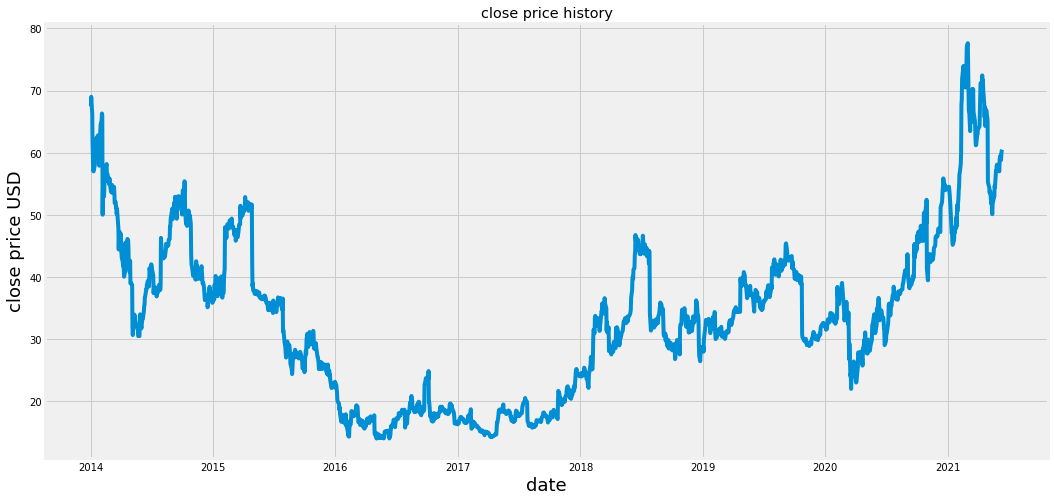

In [ ]:
# check out the closing price history
plt.figure(figsize=(16,8))
plt.title('close price history')
plt.plot(df['Close'])
plt.xlabel('date', fontsize=18)
plt.ylabel('close price USD', fontsize=18)
plt.show()

In [ ]:
# new df with close col
data = df.filter(['Close'])

# convert to np array and calc rows to train at 80%
dataset = data.values
training_data_len = math.ceil(len(dataset) * .8)
training_data_len

1500

In [ ]:
# Scale the data between 0-1
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.84077338],
       [0.86435087],
       [0.82175421],
       ...,
       [0.71832759],
       [0.7276014 ],
       [0.73074508]])

In [ ]:
# create training dataset
# scaled training
train_data = scaled_data[0:training_data_len, :]

# split into x and y for 60 days passthru
x_train = []
y_train = []

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])
  if i <= 60:
    print(x_train)
    print(y_train)
    print()

[array([0.84077338, 0.86435087, 0.82175421, 0.74583466, 0.71172592,
       0.67651683, 0.67573093, 0.68861995, 0.69475009, 0.74756369,
       0.73184536, 0.75746625, 0.76265327, 0.76123861, 0.76689722,
       0.75023583, 0.69003461, 0.72980196, 0.71424085, 0.77742853,
       0.79361839, 0.80540714, 0.82222575, 0.81672435, 0.56617416,
       0.63407734, 0.61160012, 0.62857595, 0.67337316, 0.66740024,
       0.68264697, 0.69427856, 0.65215344, 0.66991517, 0.65875511,
       0.65655455, 0.64366553, 0.6579692 , 0.65639739, 0.64287962,
       0.62401762, 0.63297706, 0.63454893, 0.64162219, 0.62118831,
       0.62668976, 0.62889032, 0.63643511, 0.62181706, 0.59588179,
       0.59792519, 0.58346436, 0.58519339, 0.56758881, 0.58016347,
       0.5463691 , 0.53237979, 0.47815155, 0.50785918, 0.52326313])]
[0.51336057006522]



In [ ]:
# convert x and y to numpy array and re-shape to 3D
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape


(1440, 60)

In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1440, 60, 1)

In [ ]:
# build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [ ]:
# compile model
model.compile(optimizer="adam", loss='mean_squared_error')

In [ ]:
# train model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1440/1440 [==============================] - 49s 22ms/step - loss: 0.0040


In [ ]:
# create testing dataset
# scaled values from 1440 to 1874
test_data = scaled_data[training_data_len - 60: , :]

# create data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len, :]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

In [ ]:
# convert the data to np array again!
x_test = np.array(x_test)

In [ ]:
# reshape to 3D data structure
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
# get model predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [ ]:
# evaluate model predictions, get rmse
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

13.023250370739616

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


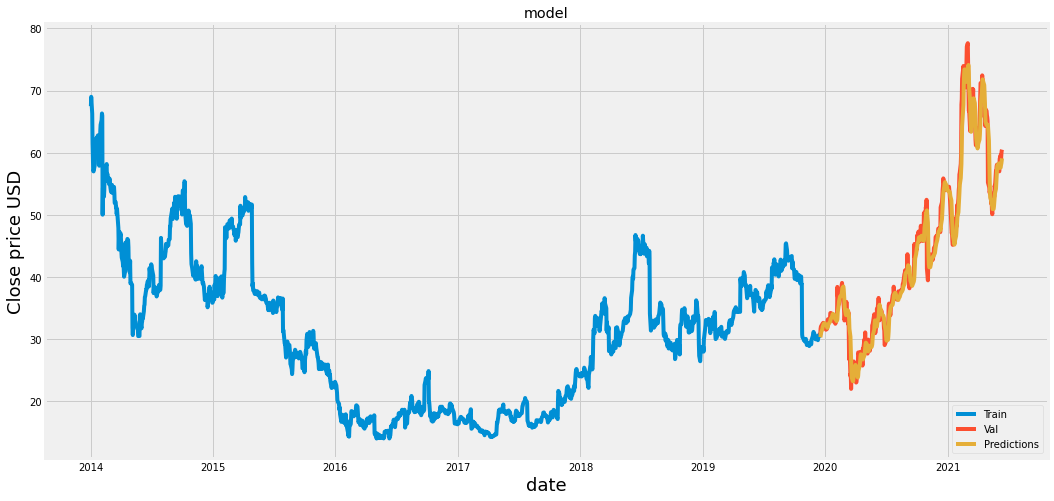

In [ ]:
# plot
train = data[:training_data_len]
valid = data[training_data_len:]
valid['predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('model')
plt.xlabel('date', fontsize=18)
plt.ylabel('Close price USD', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'predictions']])
plt.legend(['Train', "Val", 'Predictions'], loc='lower right')
plt.show()

In [ ]:
# show actual price and predicted price
valid

,Close,predictions
Date,,
2019-12-17,30.700001,30.307589
2019-12-18,31.680000,30.467512
2019-12-19,32.029999,30.781746
2019-12-20,32.130001,31.180204
2019-12-23,32.430000,31.563591
...,...,...
2021-06-07,59.630001,57.616737
2021-06-08,58.810001,58.011364
2021-06-09,59.709999,58.263435


In [ ]:
# predict stock for the next day 2021-6-14
quote = web.DataReader('TWTR', data_source='yahoo', start='2014-01-01', end='2021-06-14')
new_df = quote.filter(['Close'])

# get last 60 day values and convert to np array
last_60_days = new_df[-60:].values

#scale to 0-1 values
last_60_days_scaled = scaler.transform(last_60_days)

#create empy list and append
X_test = []
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)

# reshape
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# get predicted scale price
pred_price = model.predict(X_test)
# undo scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)


[[59.974068]]


In [ ]:
quote2 = web.DataReader('TWTR', data_source='yahoo', start='2021-06-15', end='2021-06-15')
print(quote2['Close'])


Date
2021-06-15    60.23
Name: Close, dtype: float64


In [ ]:
# NOT BAD :D